In [263]:
!python -m pip install redis tabulate haystack-ai google-ai-haystack

  Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.3
    Uninstalling protobuf-5.27.3:
      Successfully uninstalled protobuf-5.27.3


In [85]:
!python -m pip install --upgrade --force-reinstall protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.4
    Uninstalling protobuf-4.25.4:
      Successfully uninstalled protobuf-4.25.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.3 which is incompatible.


In [24]:
!python -m pip install sourcegraph==0.0.6 google-generativeai

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.2/164.2 kB 883.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 710.3 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 604.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 231.8 kB/s eta 0:00:00a 0:00:01
Using cached httplib2-0.22.0-py3-none-any.whl (96 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 380.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 215.0 kB/s eta 0:00:00a 

In [1]:
import json
import time
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import redis
from typing import List
from redis.commands.search.field import (
    Field,
    NumericField,
    TagField,
    TextField,
    VectorField,
)
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import Query
from sentence_transformers import SentenceTransformer
import google.generativeai as genai
from copy import deepcopy

/Users/ransaka/miniconda3/envs/learning/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [211]:
load_dotenv()

True

In [4]:
client = redis.Redis(
  host=os.environ['REDIS_HOST'],
  port=12305,
  password=os.environ['REDIS_PASSWORD'])

In [5]:
client.ping()

True

## 1. Loading data from github

In [6]:
from sourcegraph import Sourcegraph

gihub_repository = Sourcegraph("https://github.com/Ransaka/sinlib.git")

In [7]:
gihub_repository.run()

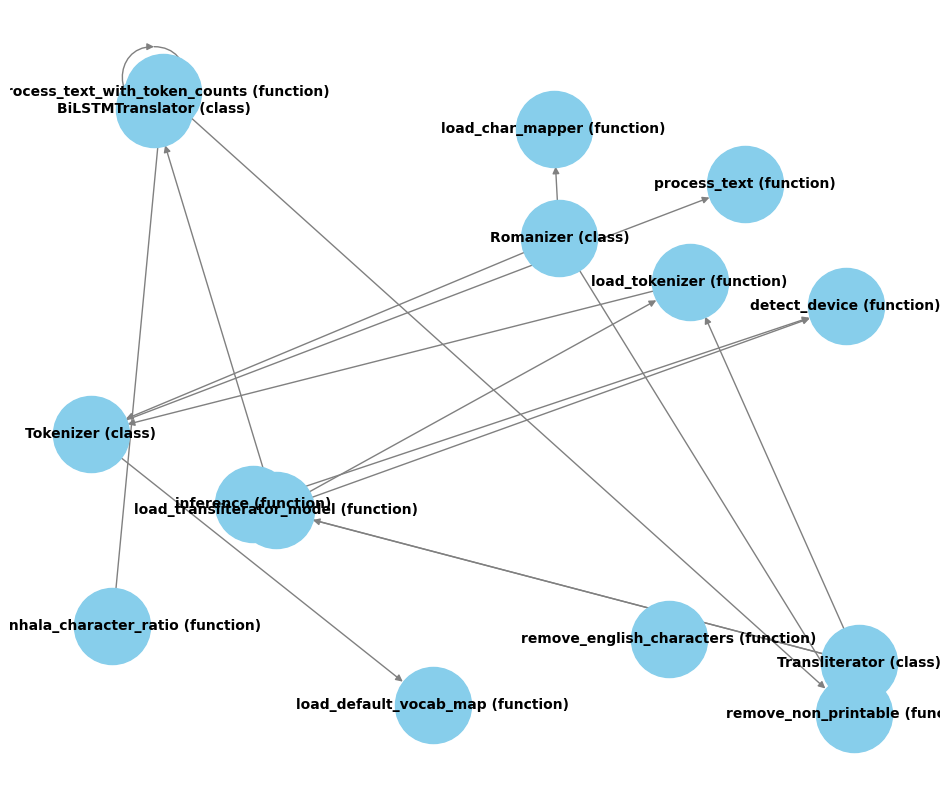

In [8]:
gihub_repository.plot()

In [9]:
gihub_repository.node_data

NodeDataView({'Romanizer': {'type': 'class', 'name': 'Romanizer', 'definition': "class Romanizer:\n\n    def __init__(self, char_mapper_fp: str, tokenizer_path: str):\n        if char_mapper_fp is None:\n            char_mapper_fp = CHAR_MAPPER_FP\n        if tokenizer_path is None:\n            tokenizer_path = DEFAULT_VOCAB_MAP_FP\n        self.char_mapper = load_char_mapper(char_mapper_fp)\n        self.tokenizer = Tokenizer(max_length=None)\n        self.tokenizer.load_from_pretrained(tokenizer_path)\n\n    def __call__(self, text):\n        return self.__romanize(text)\n\n    def __romanize(self, text: str):\n        text = remove_non_printable(text)\n        chars = np.array(list(text))\n        sinhala_mask = [True if ch in ALL_SINHALA_CHARACTERS + list(NUBERS_AND_PUNKTS) + [' '] else False for ch in chars]\n        sinhala_text = ''.join(chars[sinhala_mask]).strip()\n        encodings = self.tokenizer(sinhala_text, truncate_and_pad=False)\n        decoded_sinhala_chars = [self.

In [10]:
data = dict(deepcopy(gihub_repository.node_data))

In [11]:
data['Romanizer']

{'type': 'class',
 'name': 'Romanizer',
 'definition': "class Romanizer:\n\n    def __init__(self, char_mapper_fp: str, tokenizer_path: str):\n        if char_mapper_fp is None:\n            char_mapper_fp = CHAR_MAPPER_FP\n        if tokenizer_path is None:\n            tokenizer_path = DEFAULT_VOCAB_MAP_FP\n        self.char_mapper = load_char_mapper(char_mapper_fp)\n        self.tokenizer = Tokenizer(max_length=None)\n        self.tokenizer.load_from_pretrained(tokenizer_path)\n\n    def __call__(self, text):\n        return self.__romanize(text)\n\n    def __romanize(self, text: str):\n        text = remove_non_printable(text)\n        chars = np.array(list(text))\n        sinhala_mask = [True if ch in ALL_SINHALA_CHARACTERS + list(NUBERS_AND_PUNKTS) + [' '] else False for ch in chars]\n        sinhala_text = ''.join(chars[sinhala_mask]).strip()\n        encodings = self.tokenizer(sinhala_text, truncate_and_pad=False)\n        decoded_sinhala_chars = [self.tokenizer.token_id_to_tok

In [12]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
  system_instruction="You are optimized to generate accurate descriptions for given Python codes. When the user inputs the code, you must return the description according to its goal and functionality.  You are not allowed to generate additional details. The user expects at least 5 sentence-long descriptions.",
)

In [13]:
def get_description(code):
  chat_session = model.start_chat(
    history=[
      {
        "role": "user",
        "parts": [
          f"Code: {code}",
        ],
      },
    ]
  )
  response = chat_session.send_message("INSERT_INPUT_HERE")

  return response.text

In [14]:
for key, value in tqdm(data.items()):
    data[key]['description'] = get_description(value['definition'])
    time.sleep(2)

  0%|          | 0/15 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1722705036.264165  279548 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
100%|██████████| 15/15 [00:59<00:00,  3.96s/it]


In [16]:
for key, value in tqdm(data.items()):
    data[key]['uses'] = ", ".join(list(gihub_repository.get_dependencies(key)))

100%|██████████| 15/15 [00:00<00:00, 37471.45it/s]


In [17]:
data['Romanizer']

{'type': 'class',
 'name': 'Romanizer',
 'definition': "class Romanizer:\n\n    def __init__(self, char_mapper_fp: str, tokenizer_path: str):\n        if char_mapper_fp is None:\n            char_mapper_fp = CHAR_MAPPER_FP\n        if tokenizer_path is None:\n            tokenizer_path = DEFAULT_VOCAB_MAP_FP\n        self.char_mapper = load_char_mapper(char_mapper_fp)\n        self.tokenizer = Tokenizer(max_length=None)\n        self.tokenizer.load_from_pretrained(tokenizer_path)\n\n    def __call__(self, text):\n        return self.__romanize(text)\n\n    def __romanize(self, text: str):\n        text = remove_non_printable(text)\n        chars = np.array(list(text))\n        sinhala_mask = [True if ch in ALL_SINHALA_CHARACTERS + list(NUBERS_AND_PUNKTS) + [' '] else False for ch in chars]\n        sinhala_text = ''.join(chars[sinhala_mask]).strip()\n        encodings = self.tokenizer(sinhala_text, truncate_and_pad=False)\n        decoded_sinhala_chars = [self.tokenizer.token_id_to_tok

## 2. Store data in redis

In [18]:
for model_details in list(genai.list_models()):
    if 'embedContent' in model_details.supported_generation_methods:
        print(model_details.name,model_details.description)

I0000 00:00:1722705136.832411  279548 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


models/embedding-001 Obtain a distributed representation of a text.
models/text-embedding-004 Obtain a distributed representation of a text.


In [19]:
pipeline = client.pipeline()
for i, code_metadata in enumerate(data.values(), start=1):
    redis_key = f"code:{i:03}"
    pipeline.json().set(redis_key, "$", code_metadata)
res = pipeline.execute()

In [20]:
keys = sorted(client.keys("code:*"))
keys

[b'code:001',
 b'code:002',
 b'code:003',
 b'code:004',
 b'code:005',
 b'code:006',
 b'code:007',
 b'code:008',
 b'code:009',
 b'code:010',
 b'code:011',
 b'code:012',
 b'code:013',
 b'code:014',
 b'code:015']

In [21]:
def get_embeddings(content: List):
    return genai.embed_content(model='models/text-embedding-004',content=content)['embedding']

In [22]:
defs = client.json().mget(keys, "$.definition")
descs = client.json().mget(keys, "$.description")
embed_inputs = []

for i in range(1, len(keys)+1):
    embed_inputs.append(
        f"""{defs[i-1][0]}\n\n{descs[i-1][0]}"""
    )

In [23]:
print(embed_inputs[0])

class Romanizer:

    def __init__(self, char_mapper_fp: str, tokenizer_path: str):
        if char_mapper_fp is None:
            char_mapper_fp = CHAR_MAPPER_FP
        if tokenizer_path is None:
            tokenizer_path = DEFAULT_VOCAB_MAP_FP
        self.char_mapper = load_char_mapper(char_mapper_fp)
        self.tokenizer = Tokenizer(max_length=None)
        self.tokenizer.load_from_pretrained(tokenizer_path)

    def __call__(self, text):
        return self.__romanize(text)

    def __romanize(self, text: str):
        text = remove_non_printable(text)
        chars = np.array(list(text))
        sinhala_mask = [True if ch in ALL_SINHALA_CHARACTERS + list(NUBERS_AND_PUNKTS) + [' '] else False for ch in chars]
        sinhala_text = ''.join(chars[sinhala_mask]).strip()
        encodings = self.tokenizer(sinhala_text, truncate_and_pad=False)
        decoded_sinhala_chars = [self.tokenizer.token_id_to_token_map[c] for c in encodings]
        romanized_sinhala = [self.char_mapper.

In [24]:
embeddings = get_embeddings(embed_inputs)
VECTOR_DIMENSION = len(embeddings[0])

In [25]:
pipeline = client.pipeline()
for key, embedding in zip(keys, embeddings):
    pipeline.json().set(key, "$.embeddings", embedding)
pipeline.execute()

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [26]:
client.json().get("code:010")

{'type': 'function',
 'name': 'load_default_vocab_map',
 'definition': "def load_default_vocab_map():\n    with open(Path(DEFAULT_VOCAB_MAP_FP) / 'vocab.json', 'r') as f:\n        vocab_map = json.load(f)\n    return vocab_map",
 'file_name': 'preprocessing.py',
 'docstring': '',
 'description': 'The `load_default_vocab_map()` function is responsible for loading a vocabulary map from a JSON file. It first opens the file located at `DEFAULT_VOCAB_MAP_FP/vocab.json` in read mode. Then, it uses the `json.load()` function to parse the JSON data from the file and store it in the `vocab_map` variable. Finally, the function returns the `vocab_map`, which is a dictionary containing the vocabulary mapping. This function is likely used in a natural language processing or machine learning application where a predefined vocabulary is required for processing text data. By loading the vocabulary map from a file, the application can ensure consistency and avoid hardcoding the vocabulary within the co

In [28]:
schema = (
    TextField("$.name", no_stem=True, as_name="name"),
    TagField("$.type", as_name="type"),
    TextField("$.definition", no_stem=True, as_name="definition"),
    TextField("$.file_name", no_stem=True, as_name="file_name"),
    TextField("$.description", no_stem=True, as_name="description"),
    TextField("$.uses", no_stem=True, as_name="uses"),
    VectorField(
        "$.embeddings",
        "FLAT",
        {
            "TYPE": "FLOAT32",
            "DIM": VECTOR_DIMENSION,
            "DISTANCE_METRIC": "COSINE",
        },
        as_name="vector",
    ),
)
definition = IndexDefinition(prefix=["code:"], index_type=IndexType.JSON)
res = client.ft("idx:codes_vss").create_index(fields=schema, definition=definition)

In [29]:
info = client.ft("idx:codes_vss").info()
num_docs = info["num_docs"]
indexing_failures = info["hash_indexing_failures"]
print(f"{num_docs} documents indexed with {indexing_failures} failures")

15 documents indexed with 0 failures


In [30]:
queries = ["Tokenization operation takes a lot of time to execute in larger datasets"]

In [31]:
encoded_queries = get_embeddings(queries)

In [34]:
vector_search_query = (
    Query('(*)=>[KNN 3 @vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'id', 'name', 'definition', 'file_name', 'type', 'uses')
     .dialect(2)
)

In [35]:
client.ft('idx:codes_vss').search(
    vector_search_query,
    {
      'query_vector': np.array(encoded_queries[0], dtype=np.float32).tobytes()
    }
).docs

[Document {'id': 'code:004', 'payload': None, 'vector_score': '0.392089307308', 'name': 'load_tokenizer', 'definition': 'def load_tokenizer():\n    tokenizer = Tokenizer(max_length=MAX_LENGTH)\n    tokenizer.load_from_pretrained(DUMMY_FILE_NAME)\n    return tokenizer', 'file_name': 'dataset_utils.py', 'type': 'function', 'uses': 'Tokenizer, process_text, load_default_vocab_map'},
 Document {'id': 'code:013', 'payload': None, 'vector_score': '0.396830797195', 'name': 'process_text', 'definition': "def process_text(t):\n    tokenized_chars = []\n    for i, char in enumerate(t):\n        if char in VOWEL_DIACRITICS:\n            continue\n        if char in NUBERS_AND_PUNKTS:\n            tokenized_chars.append(char)\n        elif char == ' ':\n            tokenized_chars.append(' ')\n        elif char in ALL_LETTERS:\n            if i < len(t) - 1 and t[i + 1] in ALL_LETTERS:\n                tokenized_chars.append(char)\n            elif i < len(t) - 1 and t[i + 1] in VOWEL_DIACRITICS:\

In [253]:
def get_related_functions(query: str) -> str:
    """
    Perform a vector similarity search and retrieve related functions.

    Args:
        query (str): The input query to encode.

    Returns:
        str: A formatted string containing details of related functions.
    """
    INDEX_NAME = "idx:codes_vss"
    vector_search_query = (
            Query('(*)=>[KNN 3 @vector $query_vector AS vector_score]')
            .sort_by('vector_score')
            .return_fields('vector_score', 'id', 'name', 'definition', 'file_name', 'type', 'uses')
            .dialect(2)
        )
    
    encoded_query = get_embeddings(query)
    vector_params = {
        "query_vector": np.array(encoded_query, dtype=np.float32).tobytes()
    }
    
    # Perform initial vector search
    result_docs = client.ft(INDEX_NAME).search(vector_search_query, vector_params).docs
    
    # Extract related function names and uses
    related_items: List[str] = []
    for doc in result_docs:
        related_items.append(doc.name)
        related_items.extend(use for use in doc.uses.split(", ") if use)
    
    # Construct and execute secondary search query
    secondary_query = Query(f"@name:({' | '.join(set(related_items))})").return_fields(
        'id', 'name', 'definition', 'file_name', 'type'
    )
    docs = client.ft(INDEX_NAME).search(secondary_query).docs
    
    # Format results
    formatted_results = []
    for doc in docs:
        formatted_results.append(
            f"User Question: {query}\n\n"
            f"{'*' * 28} CODE SNIPPET {doc.id} {'*' * 28}\n"
            f"* Name: {doc.name}\n"
            f"* File: {doc.file_name}\n"
            f"* {doc.type.capitalize()} definition:\n"
            f"```python\n{doc.definition}\n```\n"
        )
    
    return "\n\n".join(formatted_results)

In [254]:
result = get_related_functions(queries)

In [255]:
print(result)

User Question: ['Tokenization operation takes a lot of time to execute in larger datasets']

**************************** CODE SNIPPET code:004 ****************************
* Name: load_tokenizer
* File: dataset_utils.py
* Function definition:
```python
def load_tokenizer():
    tokenizer = Tokenizer(max_length=MAX_LENGTH)
    tokenizer.load_from_pretrained(DUMMY_FILE_NAME)
    return tokenizer
```


User Question: ['Tokenization operation takes a lot of time to execute in larger datasets']

**************************** CODE SNIPPET code:010 ****************************
* Name: load_default_vocab_map
* File: preprocessing.py
* Function definition:
```python
def load_default_vocab_map():
    with open(Path(DEFAULT_VOCAB_MAP_FP) / 'vocab.json', 'r') as f:
        vocab_map = json.load(f)
    return vocab_map
```


User Question: ['Tokenization operation takes a lot of time to execute in larger datasets']

**************************** CODE SNIPPET code:002 ****************************
* N

In [256]:
from haystack import Pipeline

In [273]:
from haystack import component
from typing import Optional, List


@component
class RedisRetreiver:
  @component.output_types(context=str)
  def run(self, query:str):
    return {"context": get_related_functions(query)}


In [279]:
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.utils import Secret
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator, GoogleAIGeminiGenerator

# get_generator = lambda : OpenAIGenerator(
#     api_key=Secret.from_env_var("GROQ_API_KEY"),
#     api_base_url="https://api.groq.com/openai/v1",
#     model="llama-3.1-70b-versatile",
#     generation_kwargs = {"max_tokens": 512}
# )
gemini = GoogleAIGeminiGenerator(api_key=Secret.from_env_var("GEMINI_API_KEY"), model='gemini-1.5-flash')

In [280]:
from haystack.components.builders import PromptBuilder

template = """
You are a helpfull agent optimized for finding issues in codes and give most accurate answers / sugestions to the user. You have provided with all nessasary codes for fixing this issue.
First you should understand user question and potential code block to look. then craft reply carefully and on-point as it allow user to find exact solution for their issue. Give codes not hust openions.

{{context}}
"""

prompt_builder = PromptBuilder(template=template)

In [281]:
pipeline = Pipeline()
pipeline.add_component(name="Retreiver", instance=RedisRetreiver())
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component("llm", gemini)
pipeline.connect("Retreiver.context", "prompt_builder")
pipeline.connect("prompt_builder", "llm")
pipeline.draw(path='pipeline.png')

In [283]:
question = "Tokenization train operation takes a lot of time to execute in larger datasets"

response = pipeline.run({"Retreiver": {"query": question}})

print(response["llm"]["replies"][0])


The slow tokenization operation on large datasets is likely caused by the `Tokenizer.train()` method, which iterates through all characters in the input text list. This process becomes inefficient when dealing with large datasets.

To optimize the tokenization process, you can implement a more efficient approach, like using a hash map to store the unique characters and their corresponding IDs. This eliminates the need to iterate through the entire text list multiple times during training.

Here's the modified code for the `Tokenizer` class incorporating the optimization:

```python
import concurrent.futures
import json
from pathlib import Path
import warnings

from preprocessing import process_text, load_default_vocab_map

class Tokenizer:

    def __init__(self, max_length: int, unknown_token: str='<unk>', pad_token: str='<pad>'):
        self.unknown_token_id = None
        self.token_id_to_token_map = None
        self.vocab_map = None
        self.unknown_token = unknown_token
    